<br><br><br><br>
<h1>03. Analyzing and managing my portfolio</h1>

<p>Or something</p>

<br><br><br><br>
<h2>0. Document setup</h2>

In [46]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))



import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Dict, Union, Optional
from scipy.stats import kendalltau, spearmanr, kstest, uniform, norm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import t as tdist
from scipy.special import gammaln
from scipy.optimize import minimize_scalar, minimize
from dataclasses import dataclass
from typing import Callable, Dict, Any, Optional, Sequence, Tuple
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.stats import multivariate_normal, multivariate_t






from src.data_handlers.yfinance_data_loader import load_prices, load_prices_many
from src.utils.visualization import plot_price_overview
from src.utils.data_handlers import compute_log_returns
from src.utils.visualization import plot_log_returns_overview
from src.utils.visualization import plot_acf_scaled_grid
from src.data_handlers.yfinance_data_loader import load_prices_many
from src.utils.data_handlers import mean_tests_for_assets
from src.utils.data_handlers import fit_vol_models_many_assets, select_best_models, extract_vol_and_std_resid
from src.utils.visualization import plot_vol_and_resid_grid
from src.utils.data_handlers import compute_corr_matrices
from src.utils.visualization import plot_corr_heatmaps
from src.utils.portfolio_analysis import compute_markowitz_points_with_rf
from src.utils.visualization import plot_return_vs_risk
from src.utils.data_handlers import dict_series_to_panel
from src.utils.portfolio_analysis import compute_windowed_markowitz_garch, flatten_window_points
from src.utils.portfolio_analysis import compare_portfolios_markowitz
from src.utils.visualization import plot_portfolio_comparison_return_risk
from src.utils.visualization import plot_return_vs_risk_progression



from src.utils.portfolio_analysis import (
    compute_portfolio_cum_returns,
)

from src.utils.visualization import (
    plot_portfolio_comparison_return_risk,
    plot_corr_heatmaps,
    plot_section5_portfolio_evaluation_rows,
)

from src.utils.data_handlers import (
    build_corr_panel_relative_to_current,
)




<br><br><br><br>
<h3>Portfolio config.</h3>

In [47]:
START = "2023-01-01"
END   = "2025-12-20"

# Your tickers (must match columns in log_returns)
TICKERS = ["INVE-B.ST", "BRK-B", "SPGI", "0P0000YVZ3.ST", "0P0000ULAP.ST"]


# Portfolio weights (same order as TICKERS). Must sum to 1.
WEIGHTS = {
    "BRK-B": 0.231,
    "INVE-B.ST": 0.285,
    "SPGI": 0.199,
    "0P0000YVZ3.ST": 0.219,   # Länsförsäkringar Global Index
    "0P0000ULAP.ST": 0.066,   # Spiltan Aktiefond Investmentbolag
} # sums to 0.90 -> rf weight becomes 0.10


# Risk-free (fixed-rate account) annual rate (as decimal, e.g. 0.03 = 3%)
RF_ANNUAL = 0.013

# Sampling assumptions for annualization
TRADING_DAYS = 252

<br><br><br><br>
<h2>1. Data preparation</h2>

In [48]:
tickers = TICKERS

raw_prices = load_prices_many(tickers, START, END)
list(raw_prices.keys()), {k: v.shape for k, v in raw_prices.items()}

[1/5] Loading INVE-B.ST...


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


  -> ok: 747 rows, 5 cols
[2/5] Loading BRK-B...


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


  -> ok: 745 rows, 5 cols
[3/5] Loading SPGI...


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


  -> ok: 745 rows, 5 cols
[4/5] Loading 0P0000YVZ3.ST...
  -> ok: 709 rows, 5 cols
[5/5] Loading 0P0000ULAP.ST...


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


  -> ok: 692 rows, 5 cols


(['INVE-B.ST', 'BRK-B', 'SPGI', '0P0000YVZ3.ST', '0P0000ULAP.ST'],
 {'INVE-B.ST': (747, 5),
  'BRK-B': (745, 5),
  'SPGI': (745, 5),
  '0P0000YVZ3.ST': (709, 5),
  '0P0000ULAP.ST': (692, 5)})

<br><br><br><br>
<h3>Price plots</h3>

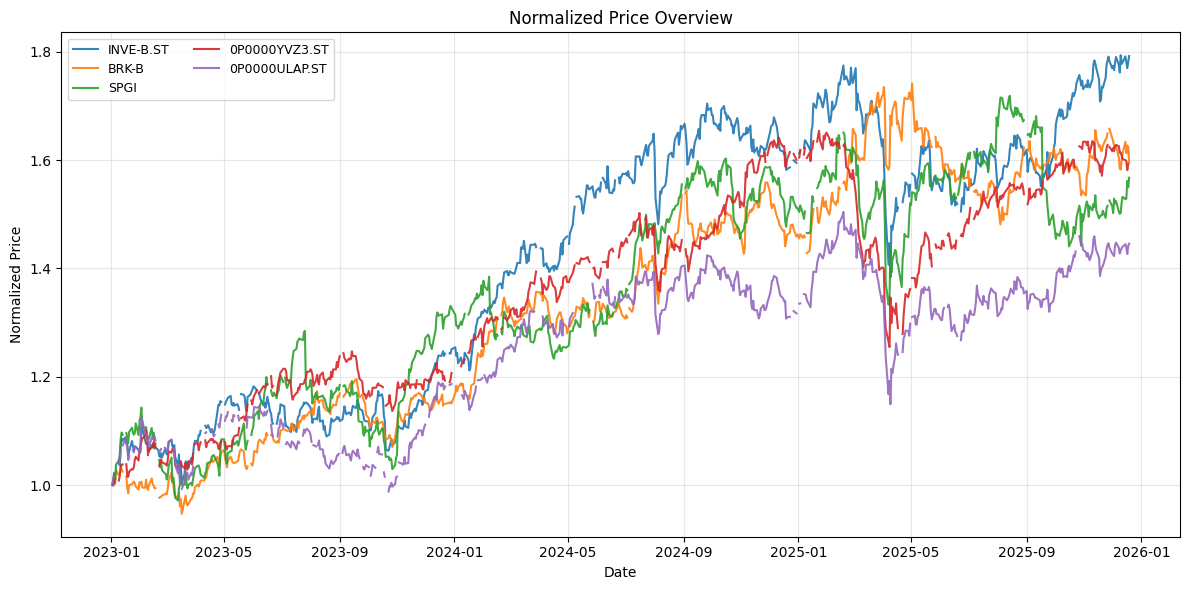

In [49]:
price_panel = plot_price_overview(raw_prices)

<br><br><br><br>
<h3>Transform to log returns and plot</h3>

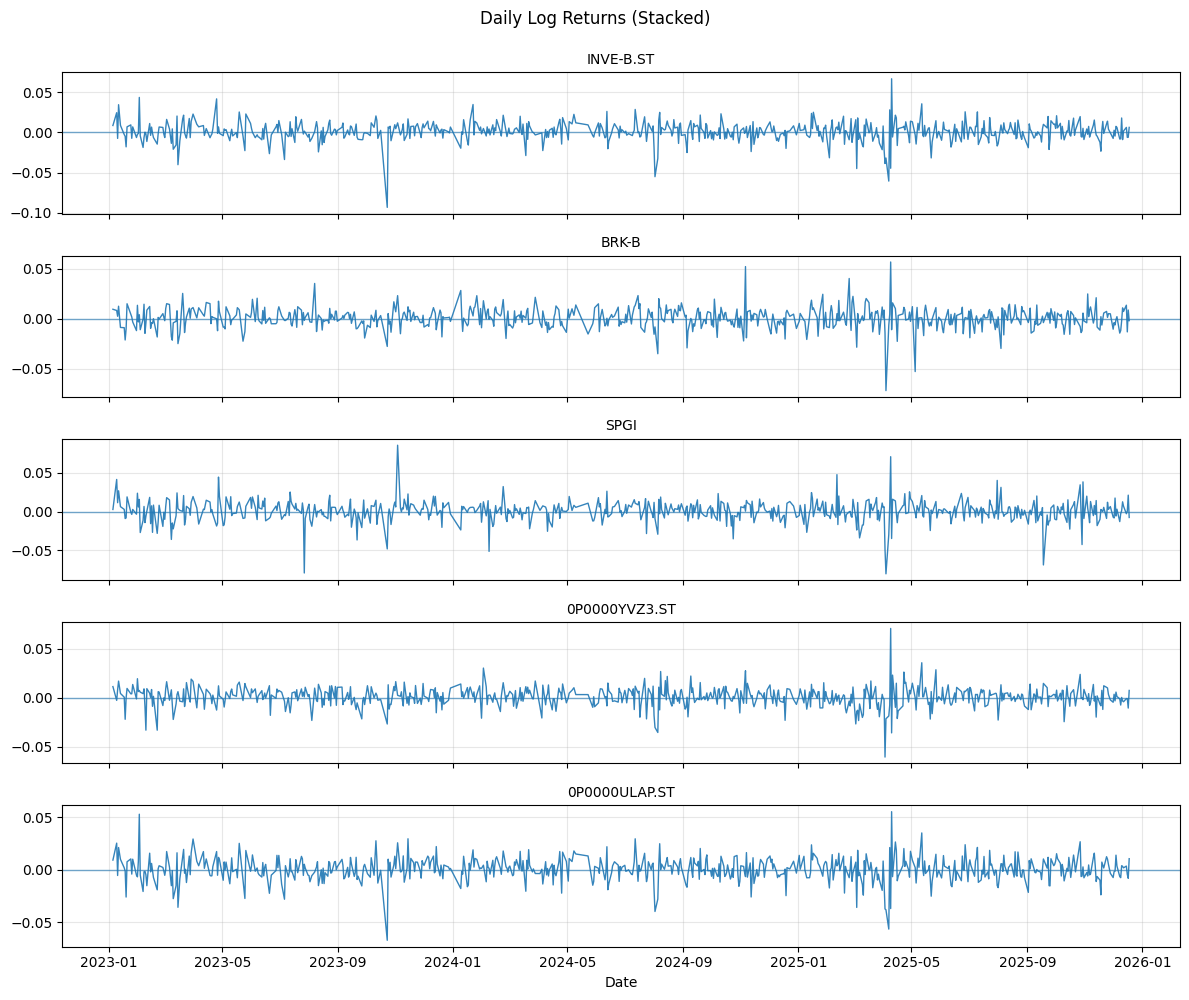

,INVE-B.ST,BRK-B,SPGI,0P0000YVZ3.ST,0P0000ULAP.ST
2023-01-05,0.008590,0.009602,0.002711,0.011225,0.009116
2023-01-09,0.024532,0.008370,0.041555,-0.002799,0.025209
2023-01-10,-0.007469,0.002595,0.011494,0.007928,-0.005497
2023-01-11,0.034501,0.012627,0.026893,0.016811,0.021021
2023-01-13,0.008770,-0.008558,0.006380,0.004248,0.009832
...,...,...,...,...,...
2025-12-12,0.001715,0.007374,0.006950,-0.004206,0.001749
2025-12-15,0.006211,0.013640,-0.002798,-0.001045,0.003419
2025-12-16,-0.006211,-0.012999,0.000460,-0.001033,-0.004491
2025-12-17,-0.006093,0.008824,0.021239,-0.010641,-0.008184


In [50]:
log_returns = compute_log_returns(raw_prices, join="inner", dropna="any")


plot_log_returns_overview(
    log_returns,
    title="Daily Log Returns (Stacked)",
    figsize=(12, 10),
)




<br><br><br><br>
<h2>2. Time series analysis</h2>

<br><br><br><br>
<h3>ACF and Absolute ACF for log returns</h3>

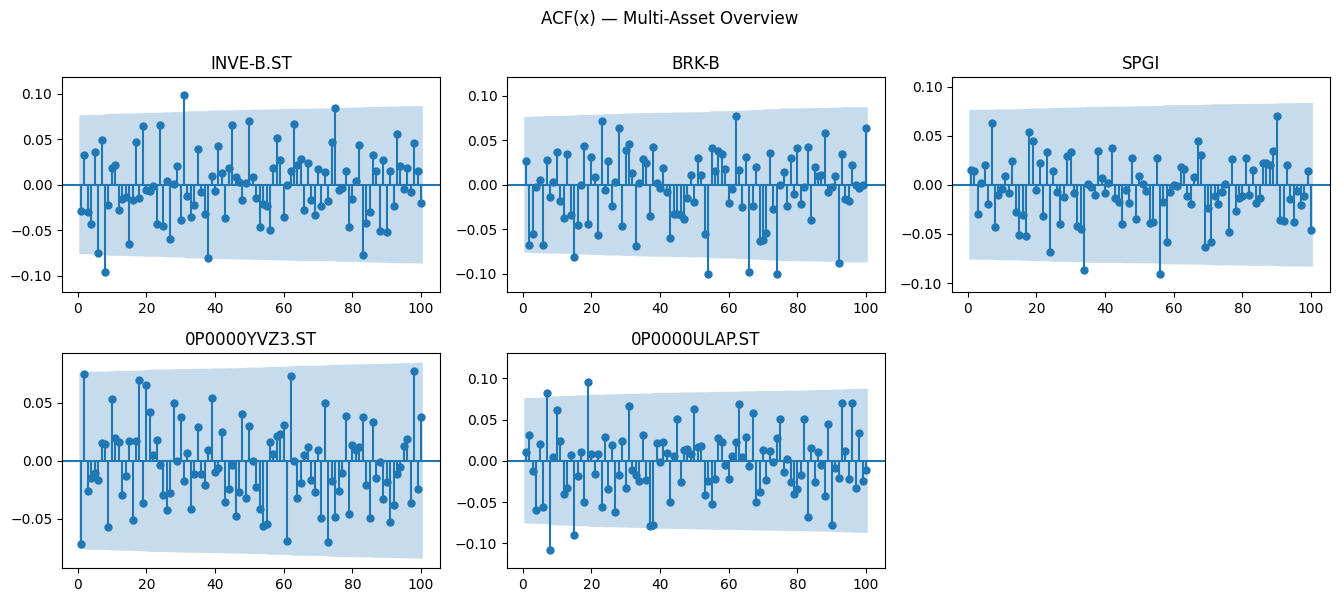

In [51]:


plot_acf_scaled_grid(
    log_returns,
    lags=100,
    conf_level=0.95,
    cols=3,
    max_assets=12,   # optional safeguard
)


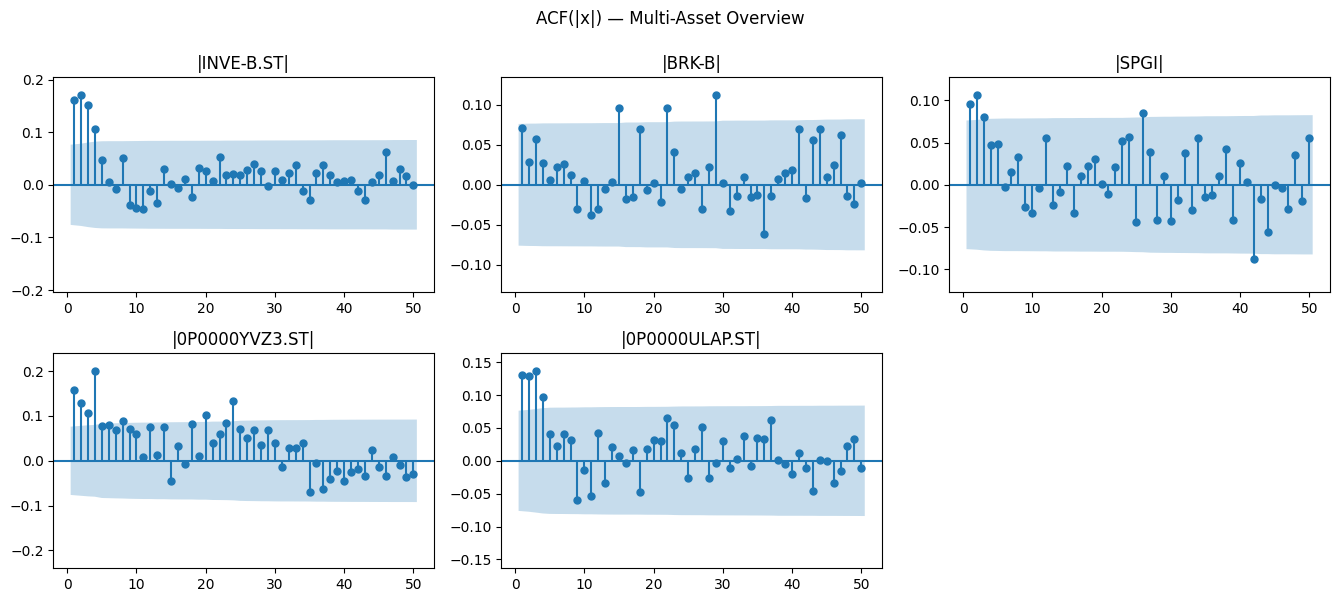

In [52]:
plot_acf_scaled_grid(log_returns, lags=50, cols=3, abs_series=True)


<br><br><br><br>
<h3>Fitting a volatility model</h3>

<br><br><br><br>
Validating that mean function is indeed constant zero.

In [53]:
mean_tests_for_assets(log_returns)


,Estimate,Std. Error,t-stat,p-value,N
Asset,,,,,
0P0000ULAP.ST,0.000536,0.000443,1.210954,0.226346,662.0
0P0000YVZ3.ST,0.000703,0.000391,1.801140,0.072137,662.0
BRK-B,0.000733,0.000405,1.807316,0.071168,662.0
INVE-B.ST,0.000857,0.000478,1.793126,0.073410,662.0
SPGI,0.000662,0.000537,1.231640,0.218522,662.0


<br><br><br><br>
Fitting volatility models by grid search.

In [54]:
results_all, fitted_all = fit_vol_models_many_assets(
    log_returns,
    mean="Constant",      # or "Zero" if you want strict
    ljungbox_lags=10,
)
results_all.head(20)


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/.venv/lib/python3.13/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001509. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/.venv/lib/python3.13/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001509. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializ

,Asset,Model,Dist,AIC,BIC,LB(z) pval,LB(|z|) pval,LB(z^2) pval,alpha+beta
0,0P0000ULAP.ST,"GARCH(1,1)",normal,-4085.954815,-4067.973753,0.020973,8.657858e-01,6.744915e-01,0.700000
1,0P0000ULAP.ST,"GARCH(2,1)",normal,-4085.410079,-4062.933751,0.020138,8.803100e-01,6.737410e-01,0.659982
2,0P0000ULAP.ST,ARCH(3),normal,-4083.105904,-4060.629577,0.017835,8.195791e-01,5.591007e-01,NaN
3,0P0000ULAP.ST,ARCH(2),normal,-4082.409069,-4064.428007,0.013940,5.859051e-01,4.829867e-01,NaN
4,0P0000ULAP.ST,"GARCH(1,2)",normal,-4081.936429,-4059.460102,0.026051,7.664728e-01,6.640206e-01,0.400000
5,0P0000ULAP.ST,ARCH(1),normal,-4074.195211,-4060.709414,0.018853,2.227699e-01,2.922469e-01,NaN
6,0P0000ULAP.ST,ARCH(2),t,-3351.951047,-3329.474719,0.016193,6.256529e-02,1.730868e-02,NaN
7,0P0000ULAP.ST,"GARCH(1,2)",t,-3319.708677,-3292.737084,0.028169,5.715089e-03,4.786409e-04,0.581862
8,0P0000ULAP.ST,"GARCH(2,1)",t,-3188.157564,-3161.185971,0.021626,1.142179e-01,1.459099e-01,0.892183
9,0P0000ULAP.ST,ARCH(3),t,-3156.732056,-3129.760463,0.023511,4.433546e-02,3.036309e-02,NaN


<br><br><br><br>
Selecting best model for each asset.

In [55]:
best = select_best_models(results_all, by="AIC")
best


,Model,Dist,AIC,BIC,LB(z) pval,LB(|z|) pval,LB(z^2) pval,alpha+beta
Asset,,,,,,,,
0P0000ULAP.ST,"GARCH(1,1)",normal,-4085.954815,-4067.973753,0.020973,0.865786,0.674492,0.700000
0P0000YVZ3.ST,"GARCH(1,1)",normal,-4276.588763,-4258.607701,0.489494,0.881305,0.007183,0.900000
BRK-B,"GARCH(1,1)",t,-4250.811874,-4228.335547,0.582697,0.999222,0.806821,0.648160
INVE-B.ST,ARCH(3),t,-4097.708880,-4070.737286,0.169408,0.541806,0.995150,NaN
SPGI,"GARCH(1,1)",normal,-3810.732698,-3792.751635,0.914401,0.963829,0.950607,0.661553


<br><br><br><br>
Extracting volatility model per asset.

In [56]:
vol_by_asset, z_by_asset = extract_vol_and_std_resid(fitted_all, best)


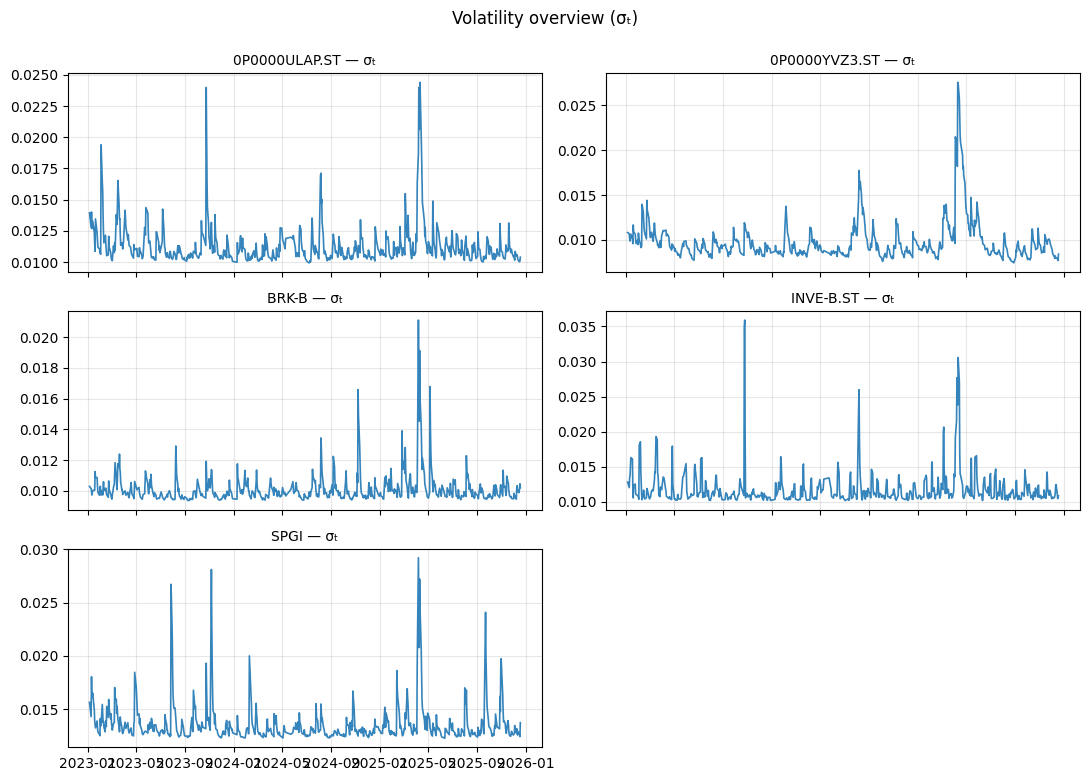

In [57]:


plot_vol_and_resid_grid(
    vol_by_asset,
    show_resid=False,
    cols=2,
    max_assets=12,
    title="Volatility overview (σₜ)",
)


<br><br><br><br>
<h2>3. Portfolio analysis on log returns</h2>

<br><br><br><br>
<h3>Correlation measures between assets</h3>

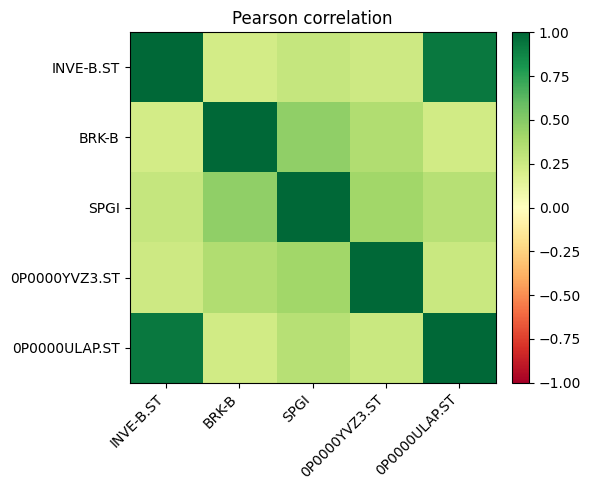

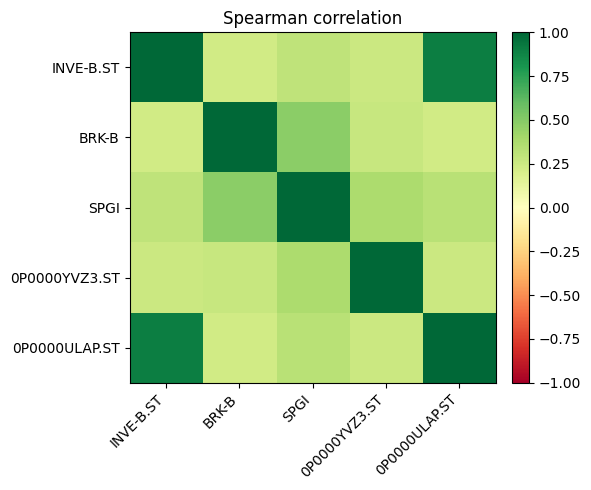

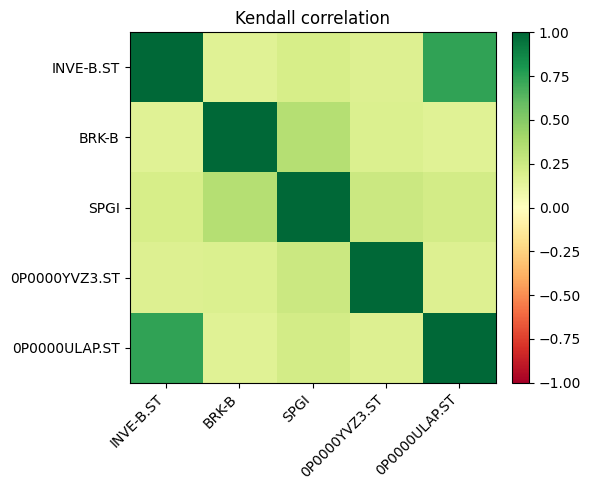

In [58]:
corrs = compute_corr_matrices(log_returns, min_periods=250)

plot_corr_heatmaps(
    corrs.pearson,
    corrs.spearman,
    corrs.kendall,
    figsize=(6, 5),
    annot=False,  # True only if small N
)

<br><br><br><br>
<h3>Calculating Markowitz points</h3>

In [59]:


# log_returns already computed earlier from your raw_prices
res = compute_markowitz_points_with_rf(
    log_returns[TICKERS],
    WEIGHTS,
    rf_annual=RF_ANNUAL,
    start=START,
    end=END,
    trading_days=TRADING_DAYS,
)



<br><br><br><br>
<h3>Risk vs. return for assets and portfolio</h3>

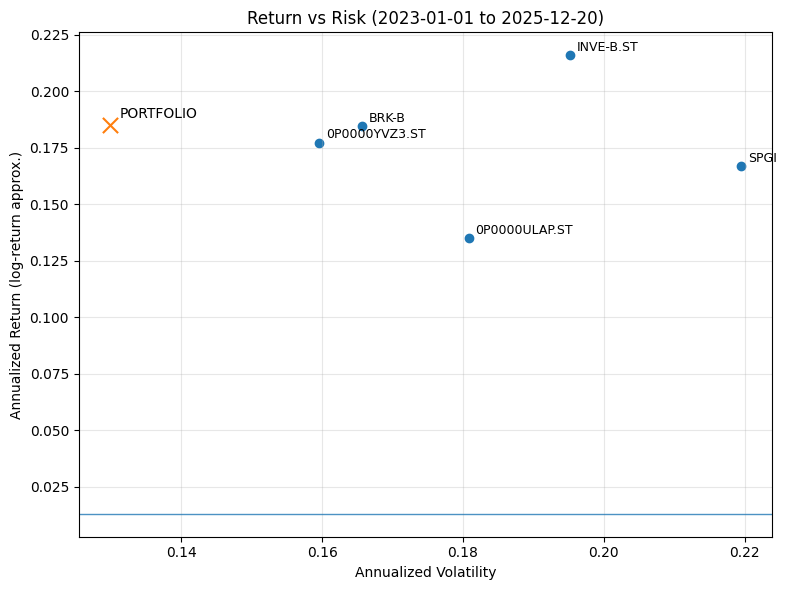

In [60]:
plot_return_vs_risk(
    res.points,
    rf_annual=RF_ANNUAL,
    title=f"Return vs Risk ({START} to {END})",
)


<br><br><br><br>
<h2>4. Portfolio analysis using fitted volatility models and residuals</h2>

In [65]:
sigma_panel = dict_series_to_panel(vol_by_asset, join="inner", start=START, end=END)
z_panel     = dict_series_to_panel(z_by_asset,   join="inner", start=START, end=END)

# returns panel aligned to same assets (and same period)
returns_panel = log_returns[sigma_panel.columns].copy()
returns_panel = returns_panel.loc[sigma_panel.index]  # align dates

<br><br><br><br>
<h3>Correlation of residuals</h3>

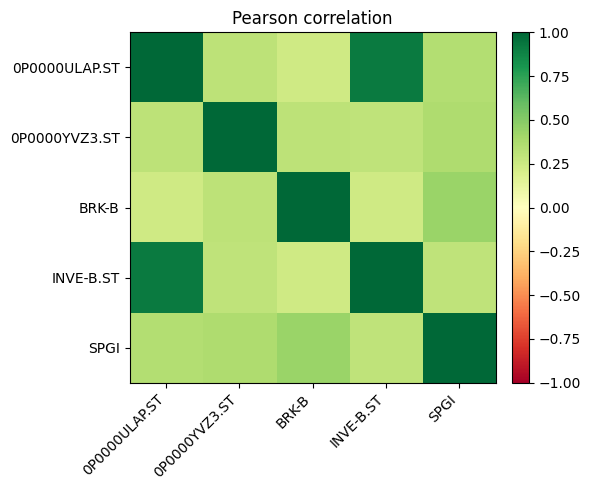

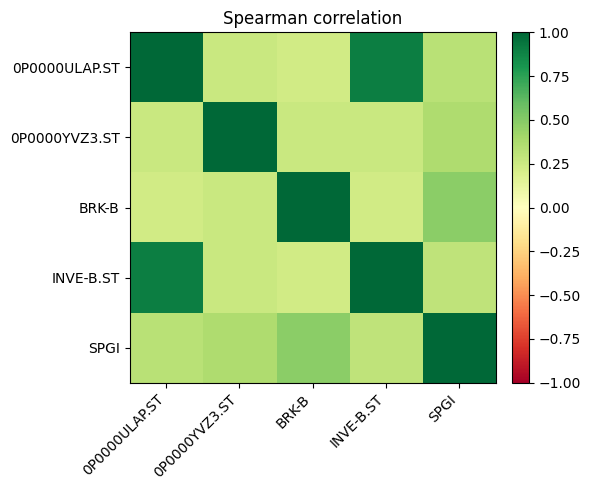

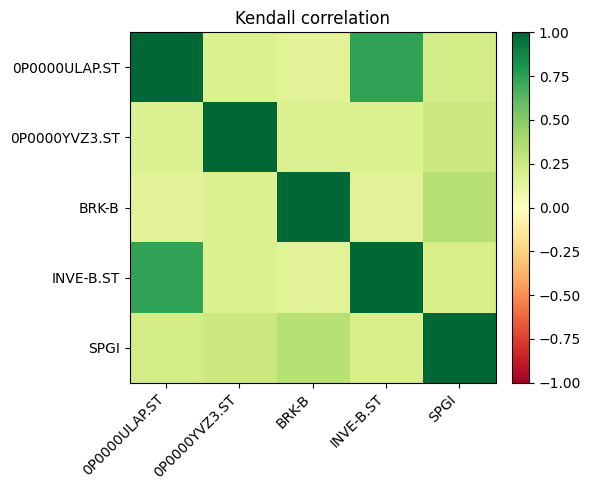

In [62]:
corrs_z = compute_corr_matrices(z_panel, min_periods=250)

plot_corr_heatmaps(
    corrs_z.pearson,
    corrs_z.spearman,
    corrs_z.kendall,
    figsize=(6, 5),
    annot=False,
)


<br><br><br><br>
<h3>Risk vs. return from fitted marginal distributions</h3>

In [63]:
window_outputs = compute_windowed_markowitz_garch(
    returns_panel=returns_panel,    # log returns; determines mean return (y-axis)
    sigma_panel=sigma_panel,        # conditional vols from GARCH; determines risk (x-axis)
    z_panel=z_panel,                # standardized residuals; used to estimate correlations
    weights=WEIGHTS,                # risky-asset weights; affects PORTFOLIO point only
    rf_annual=RF_ANNUAL,            # risk-free annual rate; shifts portfolio return vertically
    window_days=252*3,               # length of each estimation window (in trading days)
                                     # ↑ longer = smoother estimates, fewer points
    step_days=21,                    # step between windows (rebalancing frequency)
                                     # ↑ smaller = more overlap, smoother progression
    sigma_agg="mean",                # how to summarize σ_t in window:
                                     # "mean" = average risk over window
                                     # "last" = current/end-of-window risk
    corr_for_cov="pearson"           # which correlation of z_t to use in Σ = D R D
                                     # ("pearson", "spearman", "kendall")
)



points_long = flatten_window_points(window_outputs)  # long-form table for plotting
points_long.head()


""


In [66]:
plot_return_vs_risk_progression(
    points_long,
    rf_annual=RF_ANNUAL,
    cols=3,
    annotate=True,   # set False if it gets too label-heavy
    title=f"Return vs Risk — Half-year windows ({START} to {END})"
)



ValueError: points_long is empty

<br><br><br><br>
<h3>Yearly displayed risk vs. return from fitted marginal distributions</h3>

In [ ]:
window_outputs = compute_windowed_markowitz_garch(
    returns_panel=returns_panel,    # log returns; determines mean return (y-axis)
    sigma_panel=sigma_panel,        # conditional vols from GARCH; determines risk (x-axis)
    z_panel=z_panel,                # standardized residuals; used to estimate correlations
    weights=WEIGHTS,                # risky-asset weights; affects PORTFOLIO point only
    rf_annual=RF_ANNUAL,            # risk-free annual rate; shifts portfolio return vertically
    window_days=252,                # length of each estimation window (in trading days)
                                    # ↑ longer = smoother estimates, fewer points
    step_days=252,                  # step between windows (rebalancing frequency)
                                     # ↑ smaller = more overlap, smoother progression
    sigma_agg="mean",                # how to summarize σ_t in window:
                                     # "mean" = average risk over window
                                     # "last" = current/end-of-window risk
    corr_for_cov="pearson"           # which correlation of z_t to use in Σ = D R D
                                     # ("pearson", "spearman", "kendall")
)

points_long = flatten_window_points(window_outputs)  # long-form table for plotting
points_long.head()


,window_idx,start,end,asset,ann_return,ann_vol
0,0,2023-01-05,2024-03-15,0P0000ULAP.ST,0.256185,0.179942
1,0,2023-01-05,2024-03-15,0P0000YVZ3.ST,0.280084,0.150711
2,0,2023-01-05,2024-03-15,BRK-B,0.275304,0.158893
3,0,2023-01-05,2024-03-15,INVE-B.ST,0.362302,0.186886
4,0,2023-01-05,2024-03-15,SPGI,0.243995,0.219046


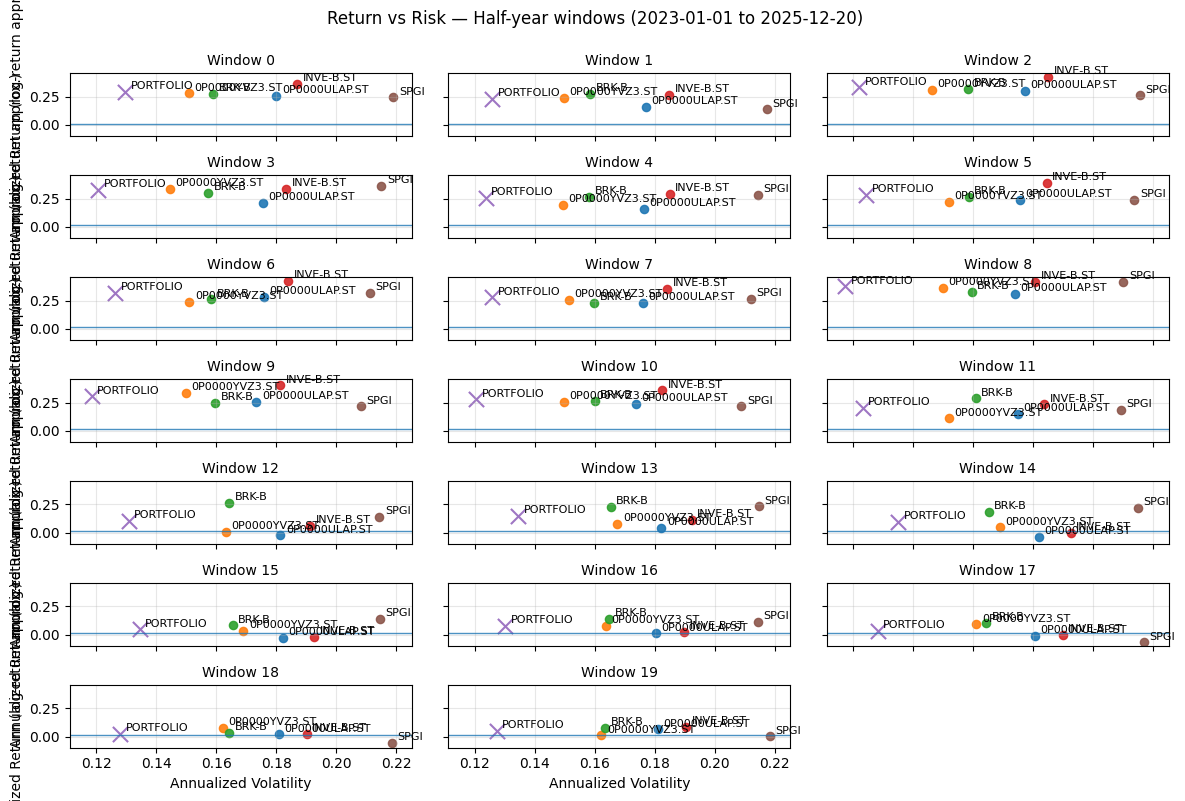

In [76]:

plot_return_vs_risk_progression(
    points_long,
    rf_annual=RF_ANNUAL,
    cols=3,
    annotate=True,   # set False if it gets too label-heavy
    title=f"Return vs Risk — Half-year windows ({START} to {END})"
)



<br><br><br><br>
<h2>5. Evaluating new portfolio options</h2>

<br><br><br><br>
<h3>Setting up new asset candidates</h3>

In [ ]:
# --- Section 5: Portfolio option evaluation universe ---
CANDIDATES = ["LLY", "JPM", "V", "ABBV"]  # add more here

BASE_TICKERS = list(WEIGHTS.keys())
UNIVERSE_TICKERS = sorted(set(BASE_TICKERS + CANDIDATES))


In [ ]:
# 1) Load prices for ALL tickers we might use (current + candidates)
raw_prices_universe = load_prices_many(UNIVERSE_TICKERS, START, END)

# 2) Compute log returns panel for the universe
log_returns_universe = compute_log_returns(raw_prices_universe, start=START, end=END)

# 3) Fit vol models for each asset (use same scaling you used earlier in your notebook)
#    If you previously fit on percent returns, keep that convention:
returns_for_garch = 100.0 * log_returns_universe[UNIVERSE_TICKERS]

results_all, fitted_all = fit_vol_models_many_assets(
    returns_for_garch,
    mean="Constant",
    ar_lags=0,
    ljungbox_lags=10,
)

best_models = select_best_models(results_all, by="AIC")

vol_by_asset, z_by_asset = extract_vol_and_std_resid(fitted_all, best_models)

sigma_panel_universe = dict_series_to_panel(vol_by_asset, join="outer")
z_panel_universe = dict_series_to_panel(z_by_asset, join="outer")

[1/9] Loading 0P0000ULAP.ST...
  -> ok: 858 rows, 5 cols
[2/9] Loading 0P0000YVZ3.ST...
  -> ok: 890 rows, 5 cols
[3/9] Loading ABBV...


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


  -> ok: 1486 rows, 5 cols
[4/9] Loading BRK-B...
  -> ok: 1486 rows, 5 cols
[5/9] Loading INVE-B.ST...
  -> ok: 1490 rows, 5 cols
[6/9] Loading JPM...
  -> ok: 1486 rows, 5 cols
[7/9] Loading LLY...
  -> ok: 1486 rows, 5 cols
[8/9] Loading SPGI...
  -> ok: 1486 rows, 5 cols
[9/9] Loading V...
  -> ok: 1486 rows, 5 cols


<br><br><br><br>
<h3>Setting up new portfolios to copare with</h3>

In [ ]:

"""# Portfolio weights (same order as TICKERS). Must sum to 1.
WEIGHTS = {
    "BRK-B": 0.231,
    "INVE-B.ST": 0.285,
    "SPGI": 0.199,
    "0P0000YVZ3.ST": 0.219,   # Länsförsäkringar Global Index
    "0P0000ULAP.ST": 0.066,   # Spiltan Aktiefond Investmentbolag
} # sums to 0.90 -> rf weight becomes 0.10"""


PORTFOLIOS = {
    "Current": WEIGHTS,
    
    "Alt_no_SPGI": {
        "BRK-B": 0.4125,
        "INVE-B.ST": 0.2625,
        "0P0000YVZ3.ST": 0.1625,
        "0P0000ULAP.ST": 0.1125,
    },

    "Alt_SPGI_to_JPM": {
    "BRK-B": 0.231,
    "INVE-B.ST": 0.285,
    "JPM": 0.199,
    "0P0000YVZ3.ST": 0.219,   # Länsförsäkringar Global Index
    "0P0000ULAP.ST": 0.066,   # Spiltan Aktiefond Investmentbolag
    },

    "Alt_SPGI_to_V": {
    "BRK-B": 0.231,
    "INVE-B.ST": 0.285,
    "V": 0.199,
    "0P0000YVZ3.ST": 0.219,   # Länsförsäkringar Global Index
    "0P0000ULAP.ST": 0.066,   # Spiltan Aktiefond Investmentbolag
    },

    "Alt_SPGI_to_ICON": {
    "BRK-B": 0.231,
    "INVE-B.ST": 0.285,
    "ABBV": 0.199,
    "0P0000YVZ3.ST": 0.219,   # Länsförsäkringar Global Index
    "0P0000ULAP.ST": 0.066,   # Spiltan Aktiefond Investmentbolag
    },

    "Alt_SPGI_to_LLY": {
    "BRK-B": 0.231,
    "INVE-B.ST": 0.285,
    "LLY": 0.199,
    "0P0000YVZ3.ST": 0.219,   # Länsförsäkringar Global Index
    "0P0000ULAP.ST": 0.066,   # Spiltan Aktiefond Investmentbolag
    }
}



port_points = compare_portfolios_markowitz(
    log_returns_universe[UNIVERSE_TICKERS],
    PORTFOLIOS,
    rf_annual=RF_ANNUAL,
    start=START,
    end=END,
    trading_days=TRADING_DAYS,
)


<br><br><br><br>
<h3>Plot comparison between portfolio alternatives</h3>

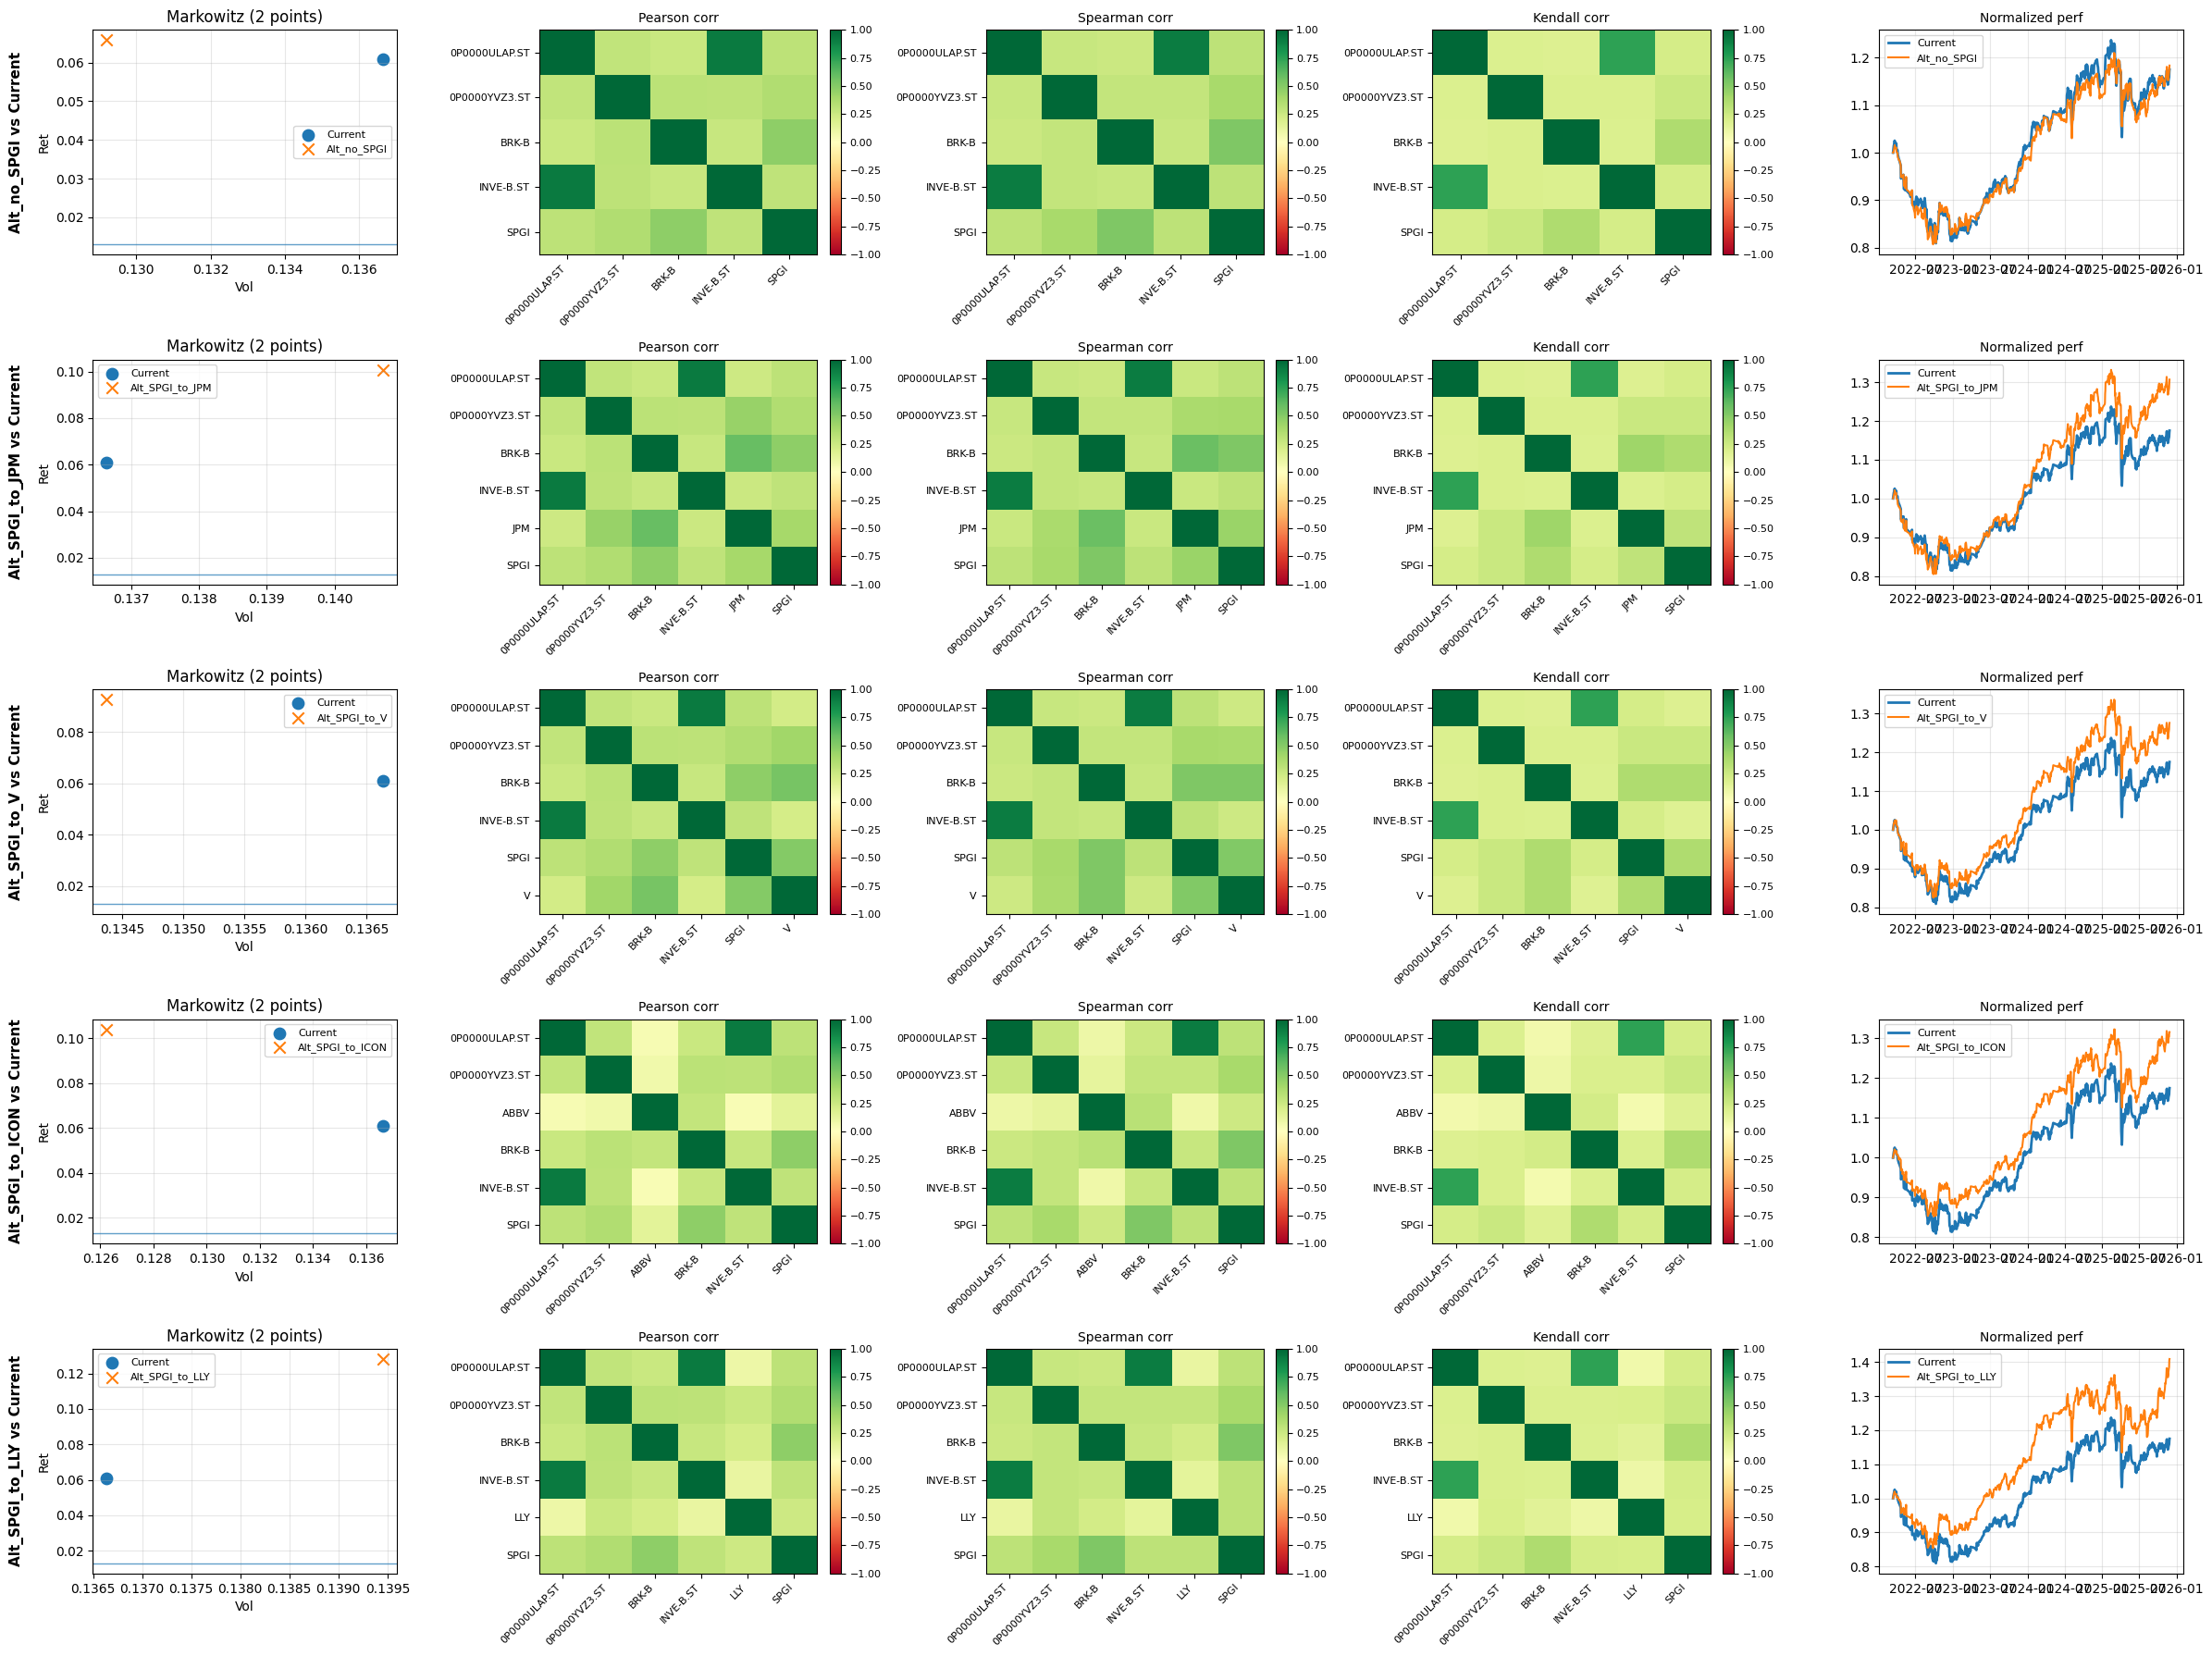

In [ ]:
plot_section5_portfolio_evaluation_rows(
    port_points=port_points,
    log_returns=log_returns_universe,
    z_panel=z_panel_universe,
    portfolios=PORTFOLIOS,
    rf_annual=RF_ANNUAL,
    start=START,
    end=END,
    current_name="Current",
    show_performance=True,
)

<br><br><br><br>
<h3>Summary plot comparison between portfolio alternatives in risk vs. return</h3>

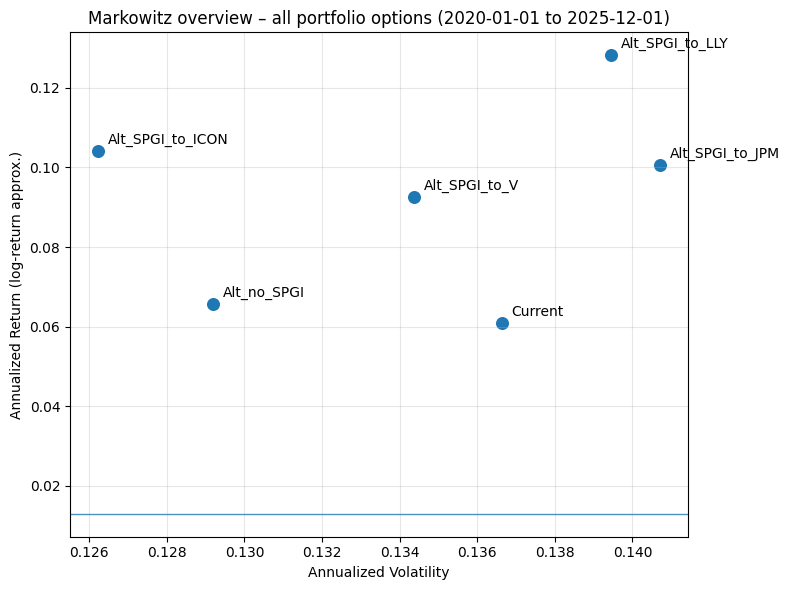

In [ ]:

plot_portfolio_comparison_return_risk(
    port_points,
    rf_annual=RF_ANNUAL,
    title=f"Markowitz overview – all portfolio options ({START} to {END})",
)